<a href="https://colab.research.google.com/github/nmq443/cognitive-science-final-project/blob/main/atcnet_cwt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# if run on colab
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

In [2]:
!pip uninstall -y keras
!pip install keras==2.15.0

Found existing installation: keras 3.2.1
Uninstalling keras-3.2.1:
  Successfully uninstalled keras-3.2.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
!git clone https://github.com/nmq443/cognitive-science-final-project.git

Cloning into 'cognitive-science-final-project'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 306 (delta 69), reused 39 (delta 13), pack-reused 167
Receiving objects: 100% (306/306), 5.88 MiB | 31.86 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [4]:
import os

# if run on colab
# os.chdir('/content/cognitive-science-final-project/')

# if run on kaggle
os.chdir('cognitive-science-final-project/')
os.getcwd()

'/kaggle/working/cognitive-science-final-project'

In [1]:
from sklearn.model_selection import train_test_split
import time
import shutil
import numpy as np
import tensorflow as tf
from sklearn.metrics import cohen_kappa_score
from preprocess import get_data
from utils import getModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from evaluation import draw_learning_curves
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score

def train_model(dataset_conf, train_conf, results_path, cwt=True):

    # remove the 'result' folder before training
    if os.path.exists(results_path):
        # Remove the folder and its contents
        shutil.rmtree(results_path)
        os.makedirs(results_path)
        
    os.makedirs(results_path + '/saved models cwt')

    # Get the current 'IN' time to calculate the overall training time
    in_exp = time.time()
    # Create a file to store the path of the best model among several runs
    best_models = open(results_path + "/best models_cwt.txt", "w")
    # Create a file to store performance during training
    log_write = open(results_path + "/log.txt", "w")

    # Get dataset paramters
    dataset = dataset_conf.get('name')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    # Get training hyperparamters
    batch_size = train_conf.get('batch_size')
    epochs = train_conf.get('epochs')
    patience = train_conf.get('patience')
    lr = train_conf.get('lr')
    LearnCurves = train_conf.get('LearnCurves') # Plot Learning Curves?
    n_train = train_conf.get('n_train')
    model_name = train_conf.get('model')
    from_logits = train_conf.get('from_logits')

    # Initialize variables
    acc = np.zeros((n_sub, n_train))
    kappa = np.zeros((n_sub, n_train))

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.

        print('\nTraining on subject ', sub+1)
        log_write.write( '\nTraining on subject '+ str(sub+1) +'\n')
        # Initiating variables to save the best subject accuracy among multiple runs.
        BestSubjAcc = 0
        bestTrainingHistory = []

        # Get training and test data
        X_train, _, y_train_onehot, _, _, _ = get_data(
            data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        if cwt:
            X_train = morlet_wavelet_transform(X_train)

        # Divide the training data into training and validation
        X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(X_train, y_train_onehot, test_size=0.2, random_state=42)

        # Iteration over multiple runs
        for train in range(n_train): # How many repetitions of training for subject i.
            # Set the random seed for TensorFlow and NumPy random number generator.
            # The purpose of setting a seed is to ensure reproducibility in random operations.
            tf.random.set_seed(train+1)
            np.random.seed(train+1)

            # Get the current 'IN' time to calculate the 'run' training time
            in_run = time.time()

            # Create folders and files to save trained models for all runs
            filepath = results_path + '/saved models cwt/run-{}'.format(train+1)
            if not os.path.exists(filepath):
                os.makedirs(filepath)
            # filepath = filepath + '/subject-{}.weights.h5'.format(sub+1)
            filepath = filepath + '/subject-{}.h5'.format(sub+1)

            # Create the model
            model = getModel(model_name, dataset_conf, from_logits)
            # Compile and train the model
            model.compile(loss=CategoricalCrossentropy(from_logits=from_logits), optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

            # model.summary()
            # plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True)

            callbacks = [
                ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                                save_best_only=True, save_weights_only=True, mode='min'),
                ReduceLROnPlateau(monitor="val_loss", factor=0.90, patience=20, verbose=0, min_lr=0.0001),
                # EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=patience)
            ]

            history = model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot),
                                epochs=epochs, batch_size=batch_size, verbose=0)

            # Evaluate the performance of the trained model based on the validation data
            # Here we load the Trained weights from the file saved in the hard
            # disk, which should be the same as the weights of the current model.
#             model.load_weights(filepath)
            y_pred = model.predict(X_val)

            if from_logits:
                y_pred = tf.nn.softmax(y_pred).numpy().argmax(axis=-1)
            else:
                y_pred = y_pred.argmax(axis=-1)

            labels = y_val_onehot.argmax(axis=-1)
            acc[sub, train]  = accuracy_score(labels, y_pred)
            kappa[sub, train] = cohen_kappa_score(labels, y_pred)

            # Get the current 'OUT' time to calculate the 'run' training time
            out_run = time.time()
            # Print & write performance measures for each run
            info = 'Subject: {}   seed {}   time: {:.1f} m   '.format(sub+1, train+1, ((out_run-in_run)/60))
            info = info + 'valid_acc: {:.4f}   valid_loss: {:.3f}'.format(acc[sub, train], min(history.history['val_loss']))
            print(info)
            log_write.write(info +'\n')
            # If current training run is better than previous runs, save the history.
            if(BestSubjAcc < acc[sub, train]):
                 BestSubjAcc = acc[sub, train]
                 bestTrainingHistory = history

        # Store the path of the best model among several runs
        best_run = np.argmax(acc[sub,:])
        # filepath = '/saved models cwt/run-{}/subject-{}.weights.h5'.format(best_run+1, sub+1)+'\n'
        filepath = '/saved models cwt/run-{}/subject-{}.h5'.format(best_run+1, sub+1)+'\n'
        best_models.write(filepath)

        # Plot Learning curves
        if (LearnCurves == True):
            print('Plot Learning Curves ....... ')
            draw_learning_curves(bestTrainingHistory, sub+1)

    # Get the current 'OUT' time to calculate the overall training time
    out_exp = time.time()

    # Print & write the validation performance using all seeds
    head1 = head2 = '         '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n---------------------------------\nValidation performance (acc %):'
    info = info + '\n---------------------------------\n' + head1 +'\n'+ head2
    for run in range(n_train):
        info = info + '\nSeed {}:  '.format(run+1)
        for sub in range(n_sub):
            info = info + '{:.2f}   '.format(acc[sub, run]*100)
        info = info + '  {:.2f}   '.format(np.average(acc[:, run])*100)
    info = info + '\n---------------------------------\nAverage acc - all seeds: '
    info = info + '{:.2f} %\n\nTrain Time  - all seeds: {:.1f}'.format(np.average(acc)*100, (out_exp-in_exp)/(60))
    info = info + ' min\n---------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Close open files
    best_models.close()
    log_write.close()

2024-05-30 09:04:25.512048: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 09:04:25.649208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getModel(model_name, dataset_conf, from_logits = False):

    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = models.ATCNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'ATCNet_CWT'):
        model = models.ATCNet_CWT(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
        )
    elif(model_name == 'EEGNet_CWT'):
        model = models.EEGNet_CWT(n_classes=n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'TCNet_Fusion'):
        # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
        model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGTCNet'):
        # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNet'):
        # Train using EEGNet: https://arxiv.org/abs/1611.08024
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNeX'):
        # Train using EEGNeX: https://arxiv.org/abs/2207.12369
        model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    elif(model_name == 'DeepConvNet'):
        # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'MBEEG_SENet'):
        # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
        model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model

In [3]:
def test(model, dataset_conf, results_path, allRuns = True):
    # Open the  "Log" file to write the evaluation results
    log_write = open(results_path + "/log.txt", "a")

    # Get dataset paramters
    dataset = dataset_conf.get('name')
    n_classes = dataset_conf.get('n_classes')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    classes_labels = dataset_conf.get('cl_labels')

    # Test the performance based on several runs (seeds)
    runs = os.listdir(results_path+"/saved models cwt")
    # Initialize variables
    acc = np.zeros((n_sub, len(runs)))
    kappa = np.zeros((n_sub, len(runs)))
    cf_matrix = np.zeros([n_sub, len(runs), n_classes, n_classes])

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    inference_time = 0 #  inference_time: classification time for one trial
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Load data
        _, _, _, X_test, _, y_test_onehot = get_data(data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        # Iteration over runs (seeds)
        for seed in range(len(runs)):
            # Load the model of the seed.
            # model.load_weights('{}/saved models cwt/{}/subject-{}.weights.h5'.format(results_path, runs[seed], sub+1))
            model.load_weights('{}/saved models cwt/{}/subject-{}.h5'.format(results_path, runs[seed], sub+1))


            inference_time = time.time()
            # Predict MI task
            y_pred = model.predict(X_test).argmax(axis=-1)
            inference_time = (time.time() - inference_time)/X_test.shape[0]
            # Calculate accuracy and K-score
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, seed]  = accuracy_score(labels, y_pred)
            kappa[sub, seed] = cohen_kappa_score(labels, y_pred)
            # Calculate and draw confusion matrix
            cf_matrix[sub, seed, :, :] = confusion_matrix(labels, y_pred, normalize='true')
            # draw_confusion_matrix(cf_matrix[sub, seed, :, :], str(sub+1), results_path, classes_labels)

    # Print & write the average performance measures for all subjects
    head1 = head2 = '                  '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n' + head1 +'\n'+ head2
    info = '\n---------------------------------\nTest performance (acc & k-score):\n'
    info = info + '---------------------------------\n' + head1 +'\n'+ head2
    for run in range(len(runs)):
        info = info + '\nSeed {}: '.format(run+1)
        info_acc = '(acc %)   '
        info_k = '        (k-sco)   '
        for sub in range(n_sub):
            info_acc = info_acc + '{:.2f}   '.format(acc[sub, run]*100)
            info_k = info_k + '{:.3f}   '.format(kappa[sub, run])
        info_acc = info_acc + '  {:.2f}   '.format(np.average(acc[:, run])*100)
        info_k = info_k + '  {:.3f}   '.format(np.average(kappa[:, run]))
        info = info + info_acc + '\n' + info_k
    info = info + '\n----------------------------------\nAverage - all seeds (acc %): '
    info = info + '{:.2f}\n                    (k-sco): '.format(np.average(acc)*100)
    info = info + '{:.3f}\n\nInference time: {:.2f}'.format(np.average(kappa), inference_time * 1000)
    info = info + ' ms per trial\n----------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Draw a performance bar chart for all subjects
    draw_performance_barChart(n_sub, acc.mean(1), 'Accuracy')
    draw_performance_barChart(n_sub, kappa.mean(1), 'k-score')
    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean((0,1)), 'All', results_path, classes_labels)
    # Close opened file
    log_write.close()

In [4]:
# from train import train_model
# from utils import getModel
# from evaluation import test
import os
import shutil
import time
import numpy as np
from preprocess import get_data
import models

In [5]:
# if run on colab
# root_datapath = '/content/drive/MyDrive'

# if run on local machine
root_datapath = '/home/quang'

# if run on kaggle
# root_datapath = '/kaggle/input/bci-competition-iv-2a'

In [6]:
import numpy as np
import random
from sklearn.linear_model import LinearRegression
from scipy import signal
import matplotlib.pyplot as plt


def morlet_wavelet_transform(X,fs=250,freq_range=(1,15),freq_bins=100,w=5):
    '''
    Discrete continous wavelet transform of eeg data convolved with complex morlet wavelet
    INPUTS:
    X - EEG data (num_trials, num_eeg_electrodes, time_bins,1)
    fs - sampling rate in Hz
    freq_range - tuple containing min and max freq range to perform analysis within
    freq_bins - number of points between freq range being analyzed
    w - Omega0 for complex morlet wavelet
    OUTPUTS:
    X_cwt - Wavlet transformed eeg data (num_trials, num_eeg_electrodes,freq_bins,time_bins)
    '''

    N_trials, _, N_eegs, time_bins = X.shape

    # values for cwt
    freq = np.linspace(freq_range[0],freq_range[1],freq_bins)
    widths = w * fs / (2 * freq * np.pi)
    X_cwt = np.zeros((N_trials, N_eegs, widths.shape[0], time_bins))

    print('Performing discrete CWT convolutions...')

    for trial in range(N_trials):
        for eeg in range(N_eegs):
            X_cwt[trial, eeg, :, :] = np.abs(signal.cwt(np.squeeze(X[trial, :, eeg, :]),signal.morlet2,widths,w=w))

    return X_cwt

In [7]:
os.getcwd()

'/home/quang/Projects/cognitive-science/cognitive-science-final-project'

In [8]:
def run():
    # Define dataset parameters
    dataset = 'BCI2a' # Options: 'BCI2a','HGD', 'CS2R'

    if dataset == 'BCI2a':
        in_samples = 1125
        n_channels = 22
        n_sub = 9
        n_classes = 4
        classes_labels = ['Left hand', 'Right hand','Foot','Tongue']
        data_path = os.path.expanduser(root_datapath) + '/BCI Competition IV/BCI Competition IV-2a/BCI Competition IV 2a mat/'
    elif dataset == 'HGD':
        in_samples = 1125
        n_channels = 44
        n_sub = 14
        n_classes = 4
        classes_labels = ['Right Hand', 'Left Hand','Rest','Feet']
        data_path = os.path.expanduser(root_datapath) + '/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/'
    elif dataset == 'CS2R':
        in_samples = 1125
        # in_samples = 576
        n_channels = 32
        n_sub = 18
        n_classes = 3
        # classes_labels = ['Fingers', 'Wrist','Elbow','Rest']
        classes_labels = ['Fingers', 'Wrist','Elbow']
        # classes_labels = ['Fingers', 'Elbow']
        data_path = os.path.expanduser(root_datapath) + '/CS2R MI EEG dataset/all/EDF - Cleaned - phase one (remove extra runs)/two sessions/'
    else:
        raise Exception("'{}' dataset is not supported yet!".format(dataset))

    # Create a folder to store the results of the experiment
    results_path = os.getcwd() + "/results"
    if not os.path.exists(results_path):
      os.makedirs(results_path)   # Create a new directory if it does not exist

    # Set dataset paramters
    dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                    'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                    'data_path': data_path, 'isStandard': True, 'LOSO': False}
    # Set training hyperparamters
    train_conf = { 'batch_size': 64, 'epochs': 100, 'patience': 10, 'lr': 0.001,'n_train': 1,
                  'LearnCurves': True, 'from_logits': False, 'model':'EEGNet_CWT'}

    # Train the model
    train_model(dataset_conf, train_conf, results_path, cwt=True)

    # Evaluate the model based on the weights saved in the '/results' folder
    model = getModel(train_conf.get('model'), dataset_conf)
#     test(model, dataset_conf, results_path)


Training on subject  1
Performing discrete CWT convolutions...


2024-05-28 02:30:09.518818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1716863420.616786      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 6s 2s/step
Subject: 1   seed 1   time: 10.0 m   valid_acc: 0.3966   valid_loss: 2.057
Plot Learning Curves ....... 


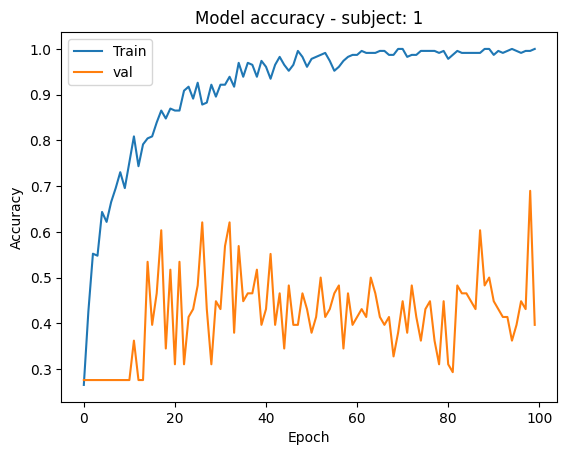

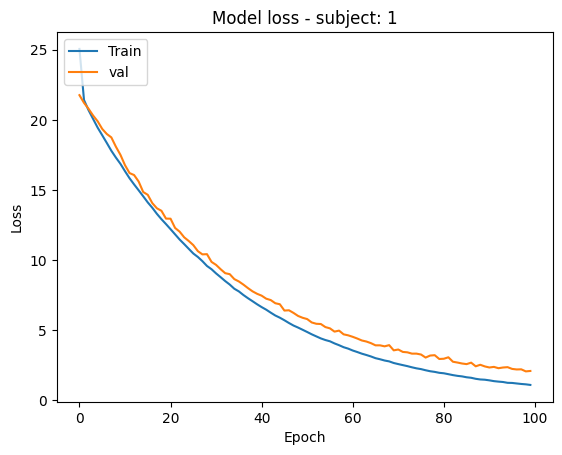


Training on subject  2
Performing discrete CWT convolutions...


2024-05-28 02:43:11.739384: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_27/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 2s 133ms/step
Subject: 2   seed 1   time: 9.3 m   valid_acc: 0.1379   valid_loss: 2.577
Plot Learning Curves ....... 


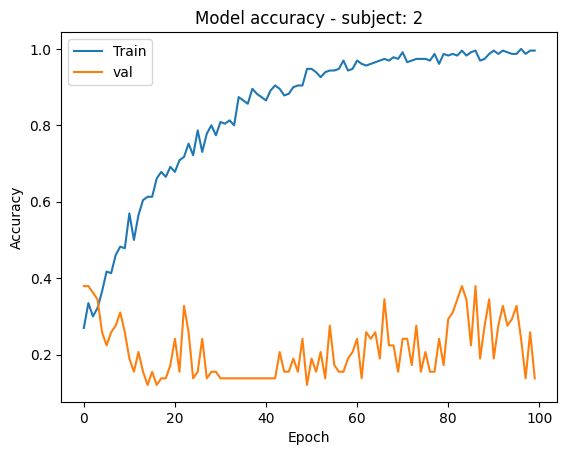

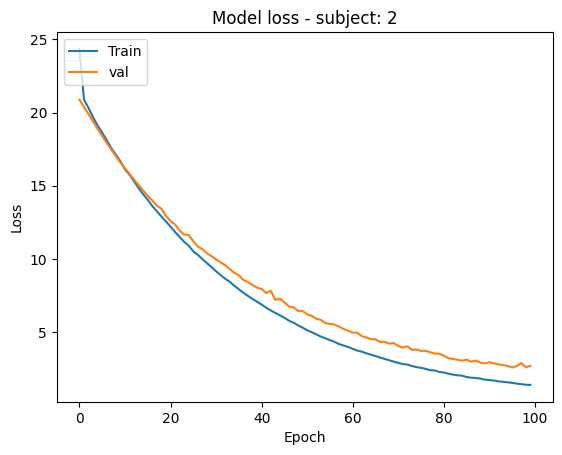


Training on subject  3
Performing discrete CWT convolutions...


2024-05-28 02:55:33.074170: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 2s 134ms/step
Subject: 3   seed 1   time: 9.3 m   valid_acc: 0.3103   valid_loss: 2.048
Plot Learning Curves ....... 


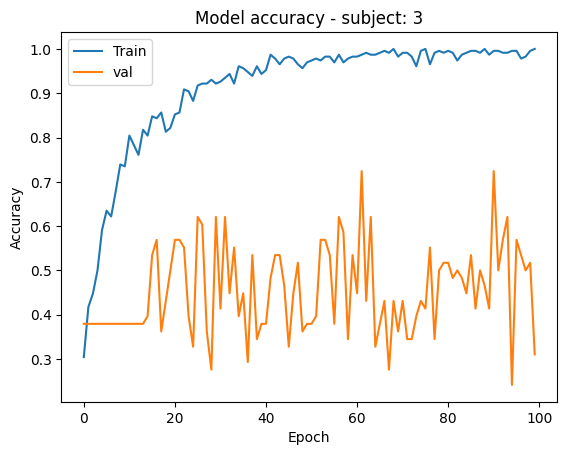

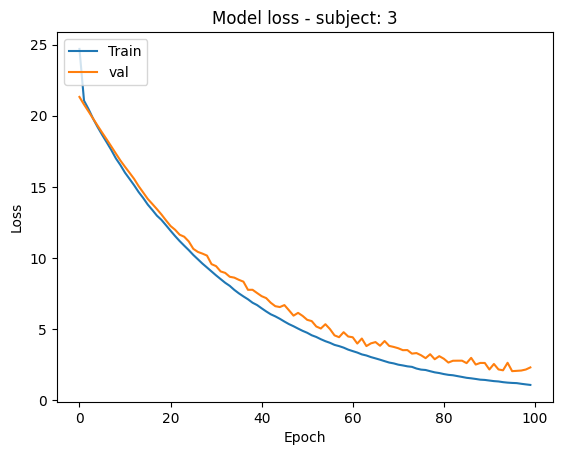


Training on subject  4
Performing discrete CWT convolutions...


2024-05-28 03:07:52.551379: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_81/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 2s 135ms/step
Subject: 4   seed 1   time: 9.3 m   valid_acc: 0.3448   valid_loss: 2.340
Plot Learning Curves ....... 


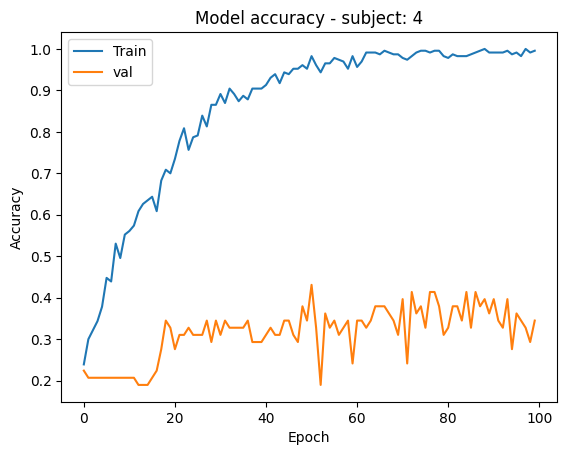

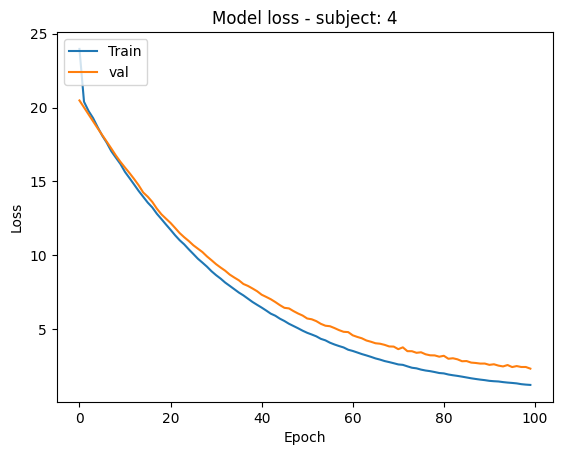


Training on subject  5
Performing discrete CWT convolutions...


2024-05-28 03:20:10.551605: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_108/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 2s 133ms/step
Subject: 5   seed 1   time: 9.3 m   valid_acc: 0.2759   valid_loss: 2.531
Plot Learning Curves ....... 


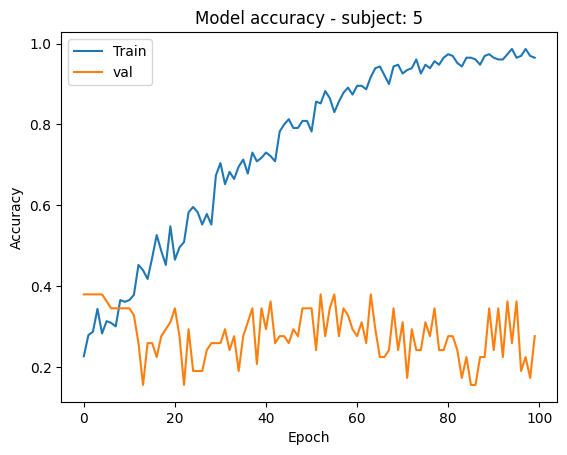

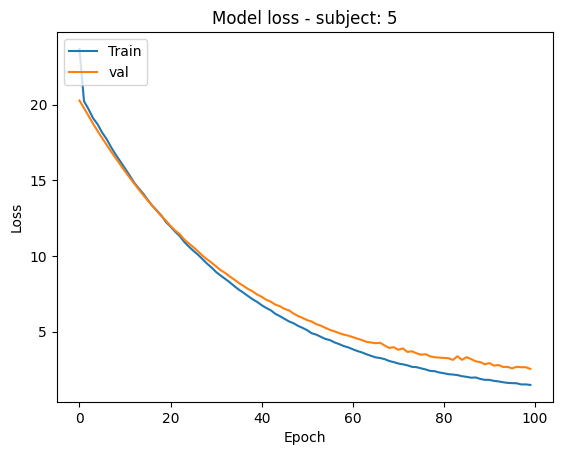


Training on subject  6
Performing discrete CWT convolutions...


2024-05-28 03:32:24.922069: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_135/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 2s 133ms/step
Subject: 6   seed 1   time: 9.3 m   valid_acc: 0.3276   valid_loss: 2.452
Plot Learning Curves ....... 


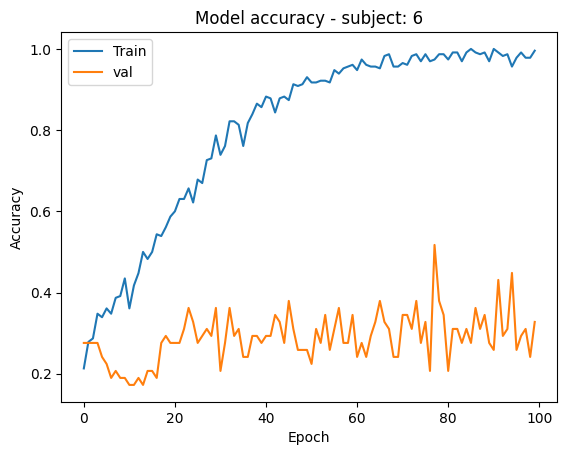

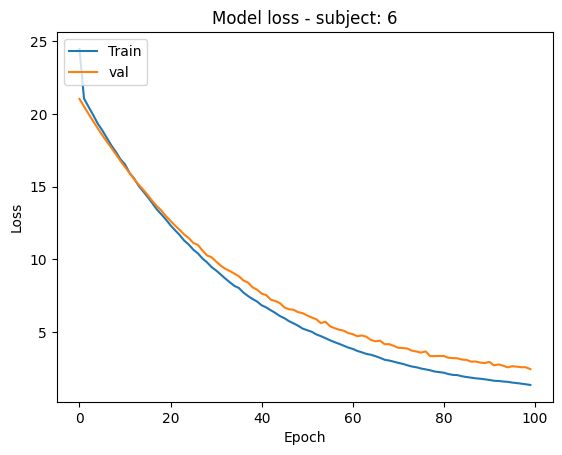


Training on subject  7
Performing discrete CWT convolutions...


2024-05-28 03:44:44.032701: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_162/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 2s 134ms/step
Subject: 7   seed 1   time: 9.3 m   valid_acc: 0.1897   valid_loss: 2.491
Plot Learning Curves ....... 


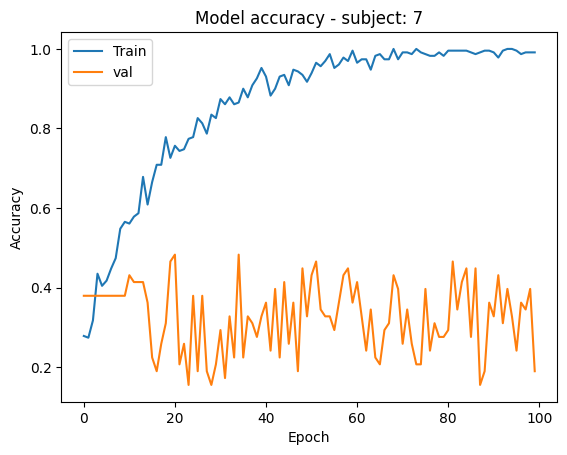

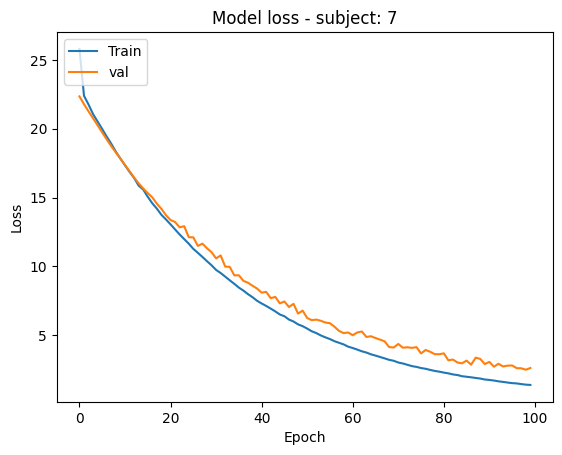


Training on subject  8
Performing discrete CWT convolutions...


2024-05-28 03:57:03.537390: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_189/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 2s 133ms/step
Subject: 8   seed 1   time: 9.3 m   valid_acc: 0.3793   valid_loss: 2.150
Plot Learning Curves ....... 


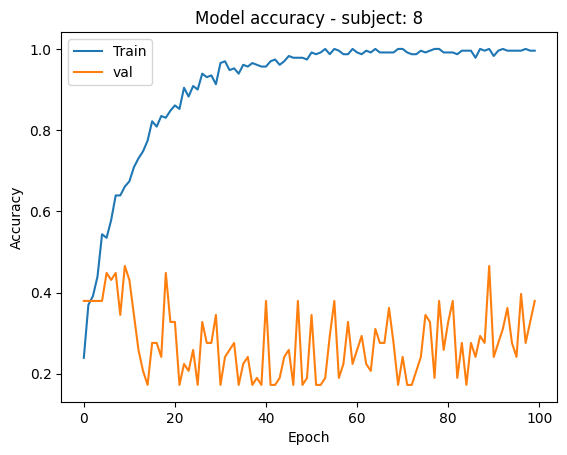

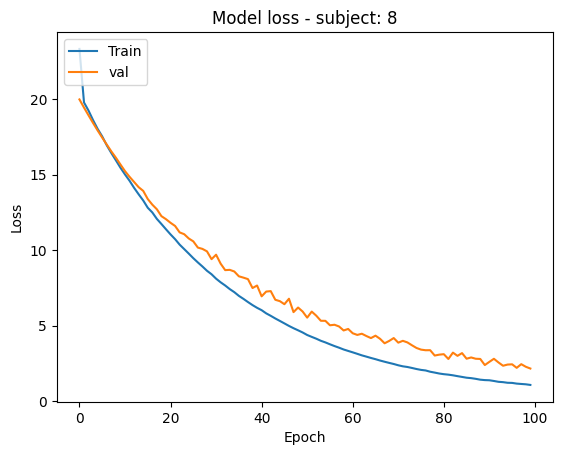


Training on subject  9
Performing discrete CWT convolutions...


2024-05-28 04:09:16.906325: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_216/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 2s 132ms/step
Subject: 9   seed 1   time: 9.3 m   valid_acc: 0.4310   valid_loss: 1.981
Plot Learning Curves ....... 


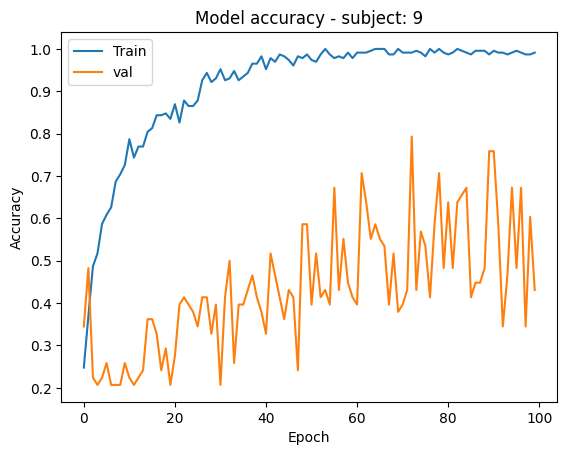

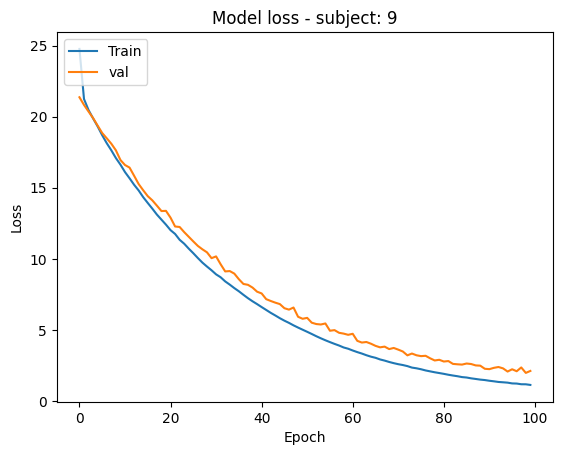


---------------------------------
Validation performance (acc %):
---------------------------------
         sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
         -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1:  39.66   13.79   31.03   34.48   27.59   32.76   18.97   37.93   43.10     31.03   
---------------------------------
Average acc - all seeds: 31.03 %

Train Time  - all seeds: 111.5 min
---------------------------------



In [13]:
run()